In [1]:
import numpy as np
from dynamic_coding_analysis.analysis_pipeline import get_data
from dynamic_coding_analysis.analysis_pipeline import process_spikes as spk
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
from tqdm import trange

C:\Users\ilow1\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# file paths
base = 'G:/My Drive/Giocomo Lab/RandomForage/'
data_folder = base + 'aggregate_data/'

In [3]:
# gain manip - grid and border cells
save_folder = base + 'Dynamic MEC Coding Project/fig3_images_supp/'

''' all 2-map, gain manip sessions '''
mice = ['Mumbai', 'Kerala', 'Goa', 'Punjab', 'Salvador'] # cue rich (new, NP9 = male)
mouse_IDs = ['9a', ' 9b', '9c', '9d', '10a']
sessions = [['1130_1', '1201_1'], # Mumbai
            ['1207_1'], # Kerala
            ['1211_1', '1210_1', '1209_1'], # Goa
            ['1217_1', '1214_1'], # Punjab
            ['1202_1'] # Salvador
           ]

print('N mice: ' + str(len(mice)))
N_sessions = 0
for s in sessions:
    N_sessions += len(s)
print('N sessions: ' + str(N_sessions))

N mice: 5
N sessions: 9


In [4]:
'''
Assign color to each mouse - colorblind friendly:
see: https://personal.sron.nl/~pault/
cue rich:
    litter 9 (dark purple): 'Mumbai', 'Kerala', 'Goa', 'Punjab'
    litter 10 (light purple): 'Salvador'
'''
colors = np.asarray([[136, 46, 114, 255], [153, 79, 136, 255], [170, 111, 158, 255], [186, 141, 180, 255], # dark purples
          [209, 187, 215, 255]]) # light purple

colors = colors/255
colors = list(colors)
for i, c in enumerate(colors):
    colors[i] = tuple(c)

In [5]:
''' get colors for each cell type
orange = grid cells
blue = border cells
'''
cell_colors = np.asarray([[241, 147, 45, 255], [25, 101, 176, 255]])
cell_colors = cell_colors/255
cell_colors = list(cell_colors)
for i, c in enumerate(cell_colors):
    cell_colors[i] = tuple(c)

In [6]:
# make a dict to hold data
data = {}
for session, m in zip(sessions, mice):
    data[m] = {}
    for s in session:
        data[m][s] = {}

In [7]:
# load the data & filter to include only cells shared between gain manip and normal trials
from pathlib import Path

for m, session in zip(mice, sessions):
    for i, s in enumerate(session):
        d = data[m][s]
        
        # gain manip
        d['Y_gm'] = np.load(data_folder + 'gain_manip/' + m + '_' + s + '_MEC_FRtensor.npy')
        d['B_gm'] = np.load(data_folder + 'gain_manip/' + m + '_' + s + '_MEC_spikes.npy')
        d['A_gm'] = np.load(data_folder + 'gain_manip/' + m + '_' + s + '_behavior.npy')  
        cells_gm = np.load(data_folder + 'gain_manip/{}_{}_MEC_cellIDs.npy'.format(m, s))
        
        # normal
        d['Y'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_FRtensor.npy')
        d['B'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_spikes.npy')
        d['A'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_behavior.npy')
        cells = np.load(data_folder + 'gap_corrected/{}_{}_MEC_cellIDs.npy'.format(m, s))
        
        # index for cells in both
        shared_cells = np.intersect1d(cells_gm, cells, assume_unique=True)
        gain_idx = np.isin(cells_gm, shared_cells)
        normal_idx = np.isin(cells, shared_cells)
        
        # filter normal trials
        d['cells'] = cells[normal_idx]
        d['Y'] = d['Y'][:, :, normal_idx]
        d['B'] = d['B'][:, normal_idx]
        filt_file = data_folder + 'gap_corrected/{}_{}_MEC_idx.npy'.format(m, s)
        if Path(filt_file).exists():
            print(m + '_' + s + ' corrected for mistargeting')
            cell_idx = np.load(filt_file)
            d['cells'] = d['cells'][cell_idx[normal_idx]]
            d['Y'] = d['Y'][:, :, cell_idx[normal_idx]]
            d['B'] = d['B'][:, cell_idx[normal_idx]]
        print('{} {}: {} shared cells'.format(m, s, d['cells'].shape[0]))
        
        # filter gain trials        
        if Path(filt_file).exists():
            filt_idx = np.isin(cells_gm, cells[cell_idx & normal_idx])
            d['Y_gm'] = d['Y_gm'][:, :, filt_idx]
            d['B_gm'] = d['B_gm'][:, filt_idx]
            d['Y_gm'] = d['Y_gm'][:, :, gain_idx[filt_idx]]
            d['B_gm'] = d['B_gm'][:, gain_idx[filt_idx]]
        else:
            d['Y_gm'] = d['Y_gm'][:, :, gain_idx]
            d['B_gm'] = d['B_gm'][:, gain_idx]

Mumbai_1130_1 corrected for mistargeting
Mumbai 1130_1: 98 shared cells
Mumbai 1201_1: 252 shared cells
Kerala 1207_1: 165 shared cells
Goa 1211_1: 137 shared cells
Goa 1210_1: 192 shared cells
Goa 1209_1: 106 shared cells
Punjab 1217_1: 140 shared cells
Punjab 1214_1: 103 shared cells
Salvador 1202_1: 186 shared cells


In [8]:
# filter out interneurons
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        excite_file = '{}reviewer_analysis/cell_type_idx/{}_{}_excitatory_idx.npy'.format(base, m, s)
        
        # filter out interneurons
        int_idx = np.load(excite_file)
        d['Y_gm'] = d['Y_gm'][:, :, int_idx]
        d['B_gm'] = d['B_gm'][:, int_idx]       
        d['Y'] = d['Y'][:, :, int_idx]
        d['B'] = d['B'][:, int_idx]
        d['cells_int'] = d['cells'].copy()
        d['cells'] = d['cells'][int_idx]        
        print('{} {}: {} putative interneurons deleted'.format(m, s, np.sum(~int_idx)))

Mumbai 1130_1: 19 putative interneurons deleted
Mumbai 1201_1: 27 putative interneurons deleted
Kerala 1207_1: 28 putative interneurons deleted
Goa 1211_1: 14 putative interneurons deleted
Goa 1210_1: 15 putative interneurons deleted
Goa 1209_1: 23 putative interneurons deleted
Punjab 1217_1: 14 putative interneurons deleted
Punjab 1214_1: 21 putative interneurons deleted
Salvador 1202_1: 33 putative interneurons deleted


In [9]:
# load grid and border indices
all_grid = np.asarray([])
all_border = np.asarray([])
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        grid_file = '{}/reviewer_analysis/cell_type_idx/{}_{}_grid_idx.npy'.format(base, m, s)
        border_file = '{}/reviewer_analysis/cell_type_idx/{}_{}_border_idx.npy'.format(base, m, s)
        
        # save grid/border indices
        grid_idx = np.load(grid_file)
        border_idx = np.load(border_file)
        d['fxn_idx'] = [grid_idx, border_idx]
        
        # save for all cells
        all_grid = np.append(all_grid, grid_idx)
        all_border = np.append(all_border, border_idx)
        
        # print cell n
        print('{}_{} n = {} total cells'.format(m, s, d['cells'].shape[0]))
        print('n = {} grid cells'.format(np.sum(grid_idx)))
        print('n = {} border cells\n'.format(np.sum(border_idx)))
        
all_grid = all_grid.astype(bool)
all_border = all_border.astype(bool)

Mumbai_1130_1 n = 79 total cells
n = 11 grid cells
n = 5 border cells

Mumbai_1201_1 n = 225 total cells
n = 39 grid cells
n = 12 border cells

Kerala_1207_1 n = 137 total cells
n = 61 grid cells
n = 9 border cells

Goa_1211_1 n = 123 total cells
n = 13 grid cells
n = 13 border cells

Goa_1210_1 n = 177 total cells
n = 28 grid cells
n = 34 border cells

Goa_1209_1 n = 83 total cells
n = 11 grid cells
n = 16 border cells

Punjab_1217_1 n = 126 total cells
n = 36 grid cells
n = 27 border cells

Punjab_1214_1 n = 82 total cells
n = 7 grid cells
n = 12 border cells

Salvador_1202_1 n = 153 total cells
n = 18 grid cells
n = 24 border cells



In [10]:
total_n_cells = 0
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        total_n_cells += d['cells_int'].shape[0]

In [11]:
# percent of all cells
n_excite_cells = all_grid.shape[0]
total_grid = np.sum(all_grid)
total_border = np.sum(all_border)
print('N cells total = {}'.format(total_n_cells))
print('N excitatory cells total = {}'.format(n_excite_cells))
print('\nN putative grid cells = {}'.format(total_grid))
print('% putative grid cells = {}%'.format(np.round((total_grid/total_n_cells)*100, 1)))
print('\nN putative border cells = {}'.format(total_border))
print('% putative border cells = {}%'.format(np.round((total_border/total_n_cells)*100, 1)))

N cells total = 1379
N excitatory cells total = 1185

N putative grid cells = 224
% putative grid cells = 16.2%

N putative border cells = 152
% putative border cells = 11.0%


In [12]:
''' K-MEANS '''
from lvl.factor_models import KMeans as lvl_kmeans
from lvl.factor_models import NMF as lvl_soft_kmeans
from scipy.spatial.distance import cdist 
from scipy.special import logsumexp
def softmax(M):
    return np.exp(M - logsumexp(M, axis=-1, keepdims=True))

In [13]:
''' fit kmeans to get remaps '''
N = 2
model_kmeans = lvl_kmeans(n_components=N, n_restarts=100)
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        Y = d['Y'].copy()
        Y = Y.transpose(0, 2, 1)
        Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
        
        # fit model and get params
        model_kmeans.fit(Y_unwrapped)
        W, H = model_kmeans.factors
        Y_hat = model_kmeans.predict()
        d['kmeans'] = {}
        d['kmeans']['W'] = W
        d['kmeans']['H'] = H
        d['kmeans']['Y_hat'] = Y_hat  

In [14]:
# reassign map 0 to be the slower map
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        A = d['A']
        W = d['kmeans']['W']
        H = d['kmeans']['H']
        
        # get map indices
        map_idx = W[:, 0].astype(bool)
        trials = A[:, 2]
        map0_idx = np.zeros_like(trials)
        map1_idx = np.zeros_like(trials)
        for i, t in enumerate(np.unique(trials)):
            if map_idx[i]:
                map0_idx[trials == t] = 1
            else:
                map1_idx[trials == t] = 1
        map0_idx = map0_idx.astype(bool)
        map1_idx = map1_idx.astype(bool)

        # get running speed in each map and assign map 0 to slower map
        speed = A[:, 1]
        speed_0 = np.nanmean(speed[map0_idx])
        speed_1 = np.nanmean(speed[map1_idx])

        if speed_1 < speed_0: # swap labels
            d['map0_idx'] = 1
        else:
            d['map0_idx'] = 0

In [15]:
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        A = d['A'].copy()

        # get map indices
        W = d['kmeans']['W']
        map0 = d['map0_idx']
        map_idx = W[:, map0].astype(bool)
        trials = A[:, 2]
        map0_idx = np.zeros_like(trials)
        map1_idx = np.zeros_like(trials)
        for i, t in enumerate(np.unique(trials)):
            if map_idx[i]:
                map0_idx[trials == t] = 1
            else:
                map1_idx[trials == t] = 1

        map0_idx = map0_idx.astype(bool)
        map1_idx = map1_idx.astype(bool)
        d['idx'] = np.row_stack((map0_idx, map1_idx))

In [16]:
def get_coordinates(tip, entry, distances):
    '''
    Convert distance from tip to 3D brain coordinates (ML, AP, DV)
    
    Params:
    ------
    tip : ndarray
        coordinates of probe tip; shape(3)
    entry : ndarray
        coordinates of probe entry into MEC; shape(3)
    distances : ndarray
        distance of each cell from probe tip; shape(n_cells)
        
    Returns:
    -------
    coords : ndarray
        coordinates of each cell; shape(n_cells, 3)
    '''
    probe_vec = (entry - tip) # vector connecting tip coords to entry coords
    l = np.linalg.norm(probe_vec) # length of the probe
    coords = tip[None, :] + (distances[:, None]/l) * probe_vec[None, :]
    
    return(coords)

In [17]:
''' get each excitatory cell's coordinates in MEC '''
hist = np.load(data_folder + '_histology.npy').item()
edges = np.arange(10, np.max(speed), 10)

for m, session in zip(mice, sessions):
    for s in session:
        sp = np.load(data_folder + m + '_' + s + '_spikeInfo.npy').item()
        d = data[m][s]
        d['sp'] = sp
        cells_unfilt = sp['cids'][sp['cgs']==2] # unsorted
        cells = d['cells'] # sorted by depth
        MEC_idx = np.isin(cells_unfilt, cells) # unsorted

        # get probe coordinates
        coords = hist[m][s]['histology']
        tip = coords[0][:-1]
        entry = coords[1]

        # get distance from tip
        depth = sp['spike_depth'].copy() # unsorted
        MEC_depth = np.sort(depth[MEC_idx]) # sort by depth

        # convert to brain coordinates
        cell_coords = get_coordinates(tip, entry, MEC_depth)
        d['cell_coords'] = cell_coords

In [18]:
MEC_cell_coords = np.asarray([])
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        cell_coords = d['cell_coords']
        if any(cell_coords[:, 1] > 824):
            print('{} {}'.format(m, s))
        if MEC_cell_coords.shape[0] == 0:
            MEC_cell_coords = cell_coords
        else:
            MEC_cell_coords = np.row_stack((MEC_cell_coords, cell_coords))

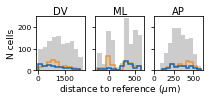

In [19]:
''' plot histograms of DV, ML, and AP coords for each unit, overlay coordinates for grid/border cells '''
gs  = gridspec.GridSpec(1, 3, wspace=0.2)
f = plt.figure(figsize=(3, 1))
LW = 1.5
GC_COLOR = cell_colors[0]
BD_COLOR = cell_colors[1]

# plot DV coords:
ax0 = plt.subplot(gs[0])
# ax0.set_yticks(np.arange(0, 2600, 500))
ax0.hist(MEC_cell_coords[:, -1], color='k', alpha=0.2)
ax0.tick_params(which='major', labelsize=7.5, pad=1)
ax0.set_title('DV', fontsize=10, pad=1.5)
ax0.set_ylabel('N cells', fontsize=9, labelpad=1)

# plot ML coords:
ax1 = plt.subplot(gs[1])
ax1.hist(MEC_cell_coords[:, 0], color='k', alpha=0.2)
ax1.tick_params(labelleft=False, which='major', labelsize=7.5, pad=1)
ax1.set_title('ML', fontsize=10, pad=1.5)
ax1.set_xlabel('distance to reference ($\mu$m)', fontsize=9, labelpad=1)

# plot AP coords:
ax2 = plt.subplot(gs[2])
ax2.hist(MEC_cell_coords[:, 1], color='k', alpha=0.2)
ax2.tick_params(labelleft=False, which='major', labelsize=7.5, pad=1)
ax2.set_title('AP', fontsize=10, pad=1.5)

# add grid and border cell locations
ax0.hist(MEC_cell_coords[all_grid, -1], color=GC_COLOR, lw=LW, histtype='step')
ax0.hist(MEC_cell_coords[all_border, -1], color=BD_COLOR,lw=LW, histtype='step')
ax1.hist(MEC_cell_coords[all_grid, 0], color=GC_COLOR, lw=LW, histtype='step')
ax1.hist(MEC_cell_coords[all_border, 0], color=BD_COLOR, lw=LW, histtype='step')
ax2.hist(MEC_cell_coords[all_grid, 1], color=GC_COLOR, lw=LW, histtype='step')
ax2.hist(MEC_cell_coords[all_border, 1], color=BD_COLOR, lw=LW, histtype='step')

# labels etc.
ax0.set_xticks([0, 1500])
ax1.set_xticks([0, 500])
ax2.set_xticks([0, 250, 500])
ax1.tick_params(labelleft=False)
ax2.tick_params(labelleft=False)
ax0.set_ylim([0, 250])
ax1.set_ylim([0, 250])
ax2.set_ylim([0, 250])

f.savefig(save_folder + 'MEC_coordinates_horizontal.png', dpi=400, bbox_inches='tight')
plt.show()

In [20]:
# calculate each cells's distance to cluster on each trial
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        Y = d['Y'].copy()
        Y = Y.transpose(0, 2, 1)
        n_trials, n_cells, n_pos = Y.shape
        
        map0_idx = d['map0_idx']
        H = d['kmeans']['H']
        N = H.shape[0]
        H_tens = H.reshape((N, n_cells, n_pos))

        # get each cluster
        c1 = H_tens[map0_idx, :, :]
        c2 = H_tens[map0_idx-1, :, :]
        
        # find the unit vector in direction connecting c1 and c2 in state space
        proj = (c1 - c2) / np.linalg.norm(c1 - c2, axis=1, keepdims=True)

        # project everything onto the same line
        projc1 = np.sum(c1 * proj, axis=1)[None, :]
        projc2 = np.sum(c2 * proj, axis=1)[None, :]
        projY = np.sum(Y * proj[None, :, :], axis=2)

        # assign 1 for in map 0 and -1 for in map 1
        dd_by_cells = (projY - projc2) / (projc1 - projc2)
        dd_by_cells = 2 * (dd_by_cells - .5)
        d['cells_dist'] = dd_by_cells.T
        
        # get ideal distribution
        dd_by_cells = dd_by_cells.T
        W = d['kmeans']['W']
        n_cells = dd_by_cells.shape[0]
        K = np.tile(W[:, d['map0_idx']-1], (n_cells, 1))

        # calculate log likelihood - try positive to rep. distance to centroid
        ll_cells = K * np.log(1 + np.exp(dd_by_cells)) + (1 - K) * np.log(1 + np.exp(-dd_by_cells))
        d['ll_cells'] = ll_cells

In [21]:
''' consistent remappers '''
avg_ll_cell_all = np.asarray([])
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        # get remap score for each cell
        avg_ll_cell = np.mean(d['ll_cells'], axis=1)
        avg_ll_cell_all = np.append(avg_ll_cell_all, avg_ll_cell)

In [22]:
''' identify spatially stable cells - stable in each map '''
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

stability_thresh = 0.25
all_stable = np.asarray([])
for m, session in zip(mice, sessions):
    for s in session:
        # load the data
        d = data[m][s]
        Y = d['Y'].copy()
        cells = d['cells']
        
        # get map indices
        W = d['kmeans']['W']
        map0 = d['map0_idx']
        map_idx = W[:, map0].astype(bool)
        
        # get cell-by-cell stability
        avg_sim0 = np.zeros(cells.shape[0])
        avg_sim1 = np.zeros(cells.shape[0])
        for i in range(Y.shape[-1]):
            y = np.squeeze(Y[:, :, i])
            y0 = y[map_idx, :]
            cell_sim = np.abs(pdist(y0, 'correlation')-1)
            avg_sim0[i] = np.mean(cell_sim)
            y1 = y[~map_idx, :]
            cell_sim = np.abs(pdist(y1, 'correlation')-1)
            avg_sim1[i] = np.mean(cell_sim)

        # save stability across both maps
        stable_cells = (avg_sim0 > stability_thresh) & (avg_sim1 > stability_thresh)
        d['stable_cells'] = stable_cells
        all_stable = np.append(all_stable, stable_cells)

all_stable = all_stable.astype(bool)        
print('n = {} stable cells (out of {} total)'.format(np.sum(all_stable), all_stable.shape[0]))

C:\Users\ilow1\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater


n = 577 stable cells (out of 1185 total)


In [178]:
# get indices and counts
nongc_nonbd_stable = all_stable & ~all_grid & ~all_border
n_gc = np.sum(all_grid)
n_bd = np.sum(all_border)
n_sp = np.sum(nongc_nonbd_stable)

In [179]:
# percent of grid vs. border vs. spatial cells that are remappers
THRESH = 1 # remappers are < thresh

gc_remappers = np.sum(avg_ll_cell_all[all_grid] < 1)
bd_remappers = np.sum(avg_ll_cell_all[all_border] < 1)
sp_remappers = np.sum(avg_ll_cell_all[nongc_nonbd_stable] < 1)

print('{} out of {} ({}%) grid cells are consistent remappers'.format(gc_remappers, n_gc, np.round((gc_remappers/n_gc)*100, 1)))
print('{} out of {} ({}%) border cells are consistent remappers'.format(bd_remappers, n_bd, np.round((bd_remappers/n_bd)*100, 1)))
print('{} out of {} ({}%) other spatial cells are consistent remappers'.format(sp_remappers, n_sp, np.round((sp_remappers/n_sp)*100, 1)))

191 out of 224 (85.3%) grid cells are consistent remappers
139 out of 152 (91.4%) border cells are consistent remappers
270 out of 309 (87.4%) other spatial cells are consistent remappers


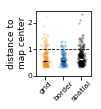

In [181]:
# plot remap score by cell type
ll_gc = avg_ll_cell_all[all_grid]
ll_bd = avg_ll_cell_all[all_border]
ll_sp = avg_ll_cell_all[nongc_nonbd_stable]
ll_means = np.asarray([np.median(ll_gc), np.median(ll_bd), np.median(ll_sp)])

# plotting params
gs = gridspec.GridSpec(1, 3, wspace=0.1)
f = plt.figure(figsize=(1.5, 1.2))
GC_COLOR = cell_colors[0]
BD_COLOR = cell_colors[1]
JIT = 0.08
PT_SIZE = 5
PT_LW = 0
SIG_SIZE = 5
BAR_SIZE = 4.3
BAR_WIDTH = 1.2
THRESH_LW = 0.8

# set jitter
j_gc = np.random.randn(n_gc) * JIT
j_bd = np.random.randn(n_bd) * JIT
j_sp = np.random.randn(n_sp) * JIT

# average distance to cluster by cell type
ax0 = plt.subplot(gs[:-1])
ax0.scatter(np.full(n_gc, 1)+j_gc, ll_gc, s=PT_SIZE, lw=PT_LW, color=GC_COLOR, alpha=0.3, zorder=1)
ax0.scatter(np.full(n_bd, 2)+j_bd, ll_bd, s=PT_SIZE, lw=PT_LW, color=BD_COLOR, alpha=0.3, zorder=1)
ax0.scatter(np.full(n_sp, 3)+j_sp, ll_sp, s=PT_SIZE, lw=PT_LW, color='k', alpha=0.3, zorder=1)
ax0.plot(np.asarray([1, 2, 3]), ll_means, '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2)
ax0.plot(3, np.median(ll_sp), '_', color='xkcd:white', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=3)

# plot threshold for consistent remappers
[xmin, xmax] = ax0.get_xlim()
ax0.hlines(1, xmin, xmax, color='k', linestyles='dashed', lw=THRESH_LW)

# mark significance
# ax0.plot(np.asarray([2, 3]), np.full(2, 2.5), '-k', lw=1, markersize=0)
# ax0.scatter(2.5, 2.6, marker='*', c='k', lw=0, s=SIG_SIZE)
# ax0.plot(np.asarray([1, 3]), np.full(2, 2.7), '-k', lw=1, markersize=0)
# ax0.scatter(np.linspace(1.93, 2.07, num=2), np.full(2, 2.8), marker='*', c='k', lw=0, s=SIG_SIZE)

ax0.tick_params(which='major', labelsize=7.5, pad=0.5)
ax0.set_yticks([0, 1, 2])
ax0.set_ylabel('distance to\nmap center', fontsize=9, labelpad=1)
ax0.set_xticks([1, 2, 3])
ax0.set_xticklabels(['grid', 'border', 'spatial'], rotation=45)

f.savefig(save_folder + 'remap_scores.png', dpi=400, bbox_inches='tight')
plt.show()

In [26]:
# statistically different?
ll_stat, ll_p = stats.kruskal(ll_gc, ll_bd, ll_sp)
print('remap scores for grid vs. border vs. other spatial (Kruskal): p = {}'.format(ll_p))
GCvsBD_stat, GCvsBD_p = stats.ranksums(ll_gc, ll_bd)
print('change in remap scores grid vs. border (rank sums): p = {}'.format(GCvsBD_p))
GCvsSP_stat, GCvsSP_p = stats.ranksums(ll_gc, ll_sp)
print('change in remap scores  grid vs. spatial (rank sums): p = {}'.format(GCvsSP_p))
SPvsBD_stat, SPvsBD_p = stats.ranksums(ll_sp, ll_bd)
print('change in remap scores spatial vs. border (rank sums): p = {}'.format(SPvsBD_p))

remap scores for grid vs. border vs. other spatial (Kruskal): p = 0.009103093378090444
change in remap scores grid vs. border (rank sums): p = 0.831549759239531
change in remap scores  grid vs. spatial (rank sums): p = 0.006940683055685206
change in remap scores spatial vs. border (rank sums): p = 0.018965120604116877


In [27]:
print('median distance to center, grid cells: {}'.format(np.round(np.median(ll_gc), 3)))
print('median distance to center, border cells: {}'.format(np.round(np.median(ll_bd), 3)))
print('median distance to center, spatial cells: {}'.format(np.round(np.median(ll_sp), 3)))

median distance to center, grid cells: 0.548
median distance to center, border cells: 0.564
median distance to center, spatial cells: 0.62


In [18]:
''' periodicity:
- examples
- preferred distance for grid vs. border cells all sessions...
'''
max_k = 5
def circ_autocorr(x):
    Fx = np.fft.fft(x)
    Fxp = np.conj(np.fft.fft(x))
    return np.roll(np.fft.ifft(Fx * Fxp).real, x.size // 2)

def ar1_acf(nt, phi, sigma2):
    """
    Computes the theoretical autocorrelation function for an AR(1) model.
    This serves as our null distribution for computing significance
    
    Params:
    -------
    nt : number of timesteps
    phi : autoregressive coefficient
    sigma2 : variance of gaussian noise
    """
    return (phi ** np.arange(nt)) * sigma2 / (1 - phi ** 2)

from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks

In [43]:
''' plot example grids/borders '''
# m = 'Kerala'
# s = '1207_1'

# m = 'Goa'
# s = '1210_1'

# m = 'Punjab'
# s = '1217_1'

m = 'Salvador'
s = '1202_1'

In [44]:
d = data[m][s]
A = d['A']
B = d['B'].copy()
Y = d['Y'].copy()
cells = d['cells'].copy()
[grid_idx, border_idx] = d['fxn_idx']

# get map indices
W = d['kmeans']['W']
map0_idx = d['idx'][0, :]
map1_idx = d['idx'][1, :]

In [45]:
# compute the firing rate by position train for each map
FR_0, binned_pos = spk.tuning_curve_bytrial(A[map0_idx, 0], A[map0_idx, 2], B[map0_idx, :],
                                                   dt=0.02, b=5, smooth=False)
FR_1, binned_pos = spk.tuning_curve_bytrial(A[map1_idx, 0], A[map1_idx, 2], B[map1_idx, :],
                                                   dt=0.02, b=5, smooth=False)
n_trials_0 = FR_0.shape[0]
n_trials_1 = FR_1.shape[0]
n_pos = FR_1.shape[1]
n_cells = FR_1.shape[2]

FR_0 = (np.reshape(FR_0, (n_trials_0*n_pos, n_cells))).T
FR_1 = (np.reshape(FR_1, (n_trials_1*n_pos, n_cells))).T

In [46]:
# find a good window to look at the signal
b = 5 # cm
pos_max = 800
cut_off = pos_max//b
L_0 = FR_0.shape[1]//2
L_stable = FR_1.shape[1]//2
cut_off

160

In [47]:
# compute null model
phi = 0.55 # decay constant to match small grid fields
s2 = 1
null_autocorr = ar1_acf(cut_off + 1, phi, s2)
null_autocorr /= null_autocorr[0]

In [48]:
# compute the autocorrelation for each map for each cell
auto_0 = np.zeros((n_cells, cut_off+1))
CI_0 = np.zeros((n_cells, cut_off+1, 2))
auto_1 = np.zeros((n_cells, cut_off+1))
CI_1 = np.zeros((n_cells, cut_off+1, 2))
for i in range(n_cells):
    # map 0
    autocorr, conf_int = acf(FR_0[i, :], fft=True, alpha=.05/cut_off, nlags=cut_off)
    auto_0[i, :] = autocorr
    CI_0[i, :, :] = conf_int

    # map 1
    autocorr, conf_int = acf(FR_1[i, :], fft=True, alpha=.05/cut_off, nlags=cut_off)
    auto_1[i, :] = autocorr
    CI_1[i, :, :] = conf_int

In [49]:
# find cells with significant peaks in each map
sig_cells_0 = np.asarray([])
sig_cells_1 = np.asarray([])
pref_distances = np.asarray([])
positions = np.arange(cut_off + 1)*b
for i in range(n_cells):
    conf_int_0 = np.squeeze(CI_0[i, :, :])
    peak_idx = find_peaks(conf_int_0[:, 0], prominence=0.05)[0]
    sig_peak_idx_0 = peak_idx[np.where(conf_int_0[:, 0][peak_idx] > null_autocorr[peak_idx])[0]]
    
    conf_int_1 = np.squeeze(CI_1[i, :, :])
    peak_idx = find_peaks(conf_int_1[:, 0], prominence=0.05)[0]
    sig_peak_idx_1 = peak_idx[np.where(conf_int_1[:, 0][peak_idx] > null_autocorr[peak_idx])[0]]
    
    if sig_peak_idx_0.shape[0] > 1:
        sig_cells_0 = np.append(sig_cells_0, i)
        
        # save cell depth and preferred distance
        n_peaks = np.min([5, sig_peak_idx_0.shape[0]])
        pref_distances = np.append(pref_distances, np.mean(positions[sig_peak_idx_0][:n_peaks]))
        
    if sig_peak_idx_1.shape[0] > 1:
        sig_cells_1 = np.append(sig_cells_1, i)
        
sig_cells_0 = sig_cells_0.astype(int)
sig_cells_1 = sig_cells_1.astype(int)

In [50]:
# normalize auto_corr for each cell
norm_auto_0 = np.zeros((sig_cells_0.shape[0], auto_0.shape[1]))
norm_auto_1 = np.zeros((sig_cells_1.shape[0], auto_1.shape[1]))
for j, i in enumerate(sig_cells_0):
    norm_auto_0[j, :] = ((auto_0[i, :] - np.min(auto_0[i, 100:])) / 
                        (np.max(auto_0[i, 100:]) - np.min(auto_0[i, 100:])))
for j, i in enumerate(sig_cells_1):
    norm_auto_1[j, :] = ((auto_1[i, :] - np.min(auto_1[i, 100:])) / 
                          (np.max(auto_1[i, 100:]) - np.min(auto_1[i, 100:])))

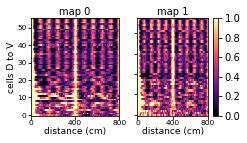

In [51]:
f, ax = plt.subplots(1, 2, figsize=(3.5, 1.8))

# map 0 autocorrelations, all periodic cells
ax[0].imshow(norm_auto_0, clim=[0, 1], aspect='auto', cmap='magma')
ax[0].set_xticks(np.arange(0, (pos_max//b)+b, 400//b))
ax[0].set_xticklabels(np.arange(0, pos_max+b, 400))
ax[0].set_ylim(ax[0].get_ylim()[::-1])
ax[0].set_title('map 0', fontsize=10, pad=3)
ax[0].set_xlabel('distance (cm)', fontsize=9, labelpad=1)
ax[0].set_ylabel('cells D to V', fontsize=9, labelpad=1)
ax[0].tick_params(which='major', labelsize=7.5, pad=0.5)

# map 1 autocorrelations, all periodic cells
im = ax[1].imshow(norm_auto_1, clim=[0, 1],aspect='auto', cmap='magma')
ax[1].set_xticks(np.arange(0, (pos_max//b)+b, 400//b))
ax[1].set_xticklabels(np.arange(0, pos_max+b, 400))
ax[1].set_ylim(ax[1].get_ylim()[::-1])
ax[1].set_title('map 1', fontsize=10, pad=3)
ax[1].set_xlabel('distance (cm)', fontsize=9, labelpad=1)
ax[1].tick_params(labelleft=False, which='major', labelsize=7.5, pad=0.5)

f.colorbar(im)
f.savefig(save_folder + m + '_' + s + '_autocorr.png', dpi=400, bbox_inches='tight')
plt.show()

In [52]:
grid_bool = grid_idx
grid_idx = np.where(grid_idx)[0]
border_bool = border_idx
border_idx = np.where(border_idx)[0]

In [53]:
auto_0_gc = np.zeros((grid_idx.shape[0], auto_0.shape[1]))
auto_1_gc = np.zeros((grid_idx.shape[0], auto_0.shape[1]))
for j, i in enumerate(grid_idx):
    auto_0_gc[j, :] = ((auto_0[i, :] - np.min(auto_0[i, 100:])) / 
                        (np.max(auto_0[i, 100:]) - np.min(auto_0[i, 100:])))
    auto_1_gc[j, :] = ((auto_1[i, :] - np.min(auto_1[i, 100:])) / 
                          (np.max(auto_1[i, 100:]) - np.min(auto_1[i, 100:])))
    
auto_0_bd = np.zeros((border_idx.shape[0], auto_1.shape[1]))
auto_1_bd = np.zeros((border_idx.shape[0], auto_1.shape[1]))
for j, i in enumerate(border_idx):
    auto_1_bd[j, :] = ((auto_0[i, :] - np.min(auto_0[i, 100:])) / 
                        (np.max(auto_0[i, 100:]) - np.min(auto_0[i, 100:])))
    auto_0_bd[j, :] = ((auto_1[i, :] - np.min(auto_1[i, 100:])) / 
                          (np.max(auto_1[i, 100:]) - np.min(auto_1[i, 100:])))

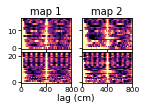

In [54]:
gs = gridspec.GridSpec(6, 2, hspace=0.4, wspace=0.2)
f = plt.figure(figsize=(2, 1.2)) 

# get ratio grid to border
n_gc = np.sum(grid_bool)
n_bd = np.sum(border_bool)
ratio = n_gc / (n_gc + n_bd)
n_rows = (np.round(ratio * 6)).astype(int)

# map 0 trial autocorrelations
# putative grid cells
ax0 = plt.subplot(gs[:n_rows, 0])
ax0.imshow(auto_0_gc, clim=[0, 1], aspect='auto', cmap='magma')
ax0.set_xticks(np.arange(0, (pos_max//b)+b, 400//b))
ax0.set_xticklabels(np.arange(0, pos_max+b, 400))
ax0.set_ylim(ax0.get_ylim()[::-1])
ax0.set_title('map 1', fontsize=10, pad=3)
# ax0.set_ylabel('gc D to V', fontsize=9, labelpad=1)
ax0.tick_params(labelbottom=False, which='major', labelsize=7.5, pad=0.5)

# putative border cells
ax1 = plt.subplot(gs[n_rows:, 0])
ax1.imshow(auto_0_bd, clim=[0, 1], aspect='auto', cmap='magma')
ax1.set_xticks(np.arange(0, (pos_max//b)+b, 400//b))
ax1.set_xticklabels(np.arange(0, pos_max+b, 400))
ax1.set_ylim(ax1.get_ylim()[::-1])
# ax1.set_ylabel('bd', fontsize=9, labelpad=1)
# ax1.set_xlabel('distance (cm)', fontsize=9, labelpad=1)
ax1.tick_params(which='major', labelsize=7.5, pad=0.5)

# map 1 trial autocorrelations
# putative grid cells
ax2 = plt.subplot(gs[:n_rows, 1])
ax2.imshow(auto_1_gc, clim=[0, 1], aspect='auto', cmap='magma')
ax2.set_xticks(np.arange(0, (pos_max//b)+b, 400//b))
ax2.set_xticklabels(np.arange(0, pos_max+b, 400))
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.set_title('map 2', fontsize=10, pad=3)
ax2.tick_params(labelleft=False, labelbottom=False, which='major', labelsize=7.5, pad=0.5)

# putative border cells
ax3 = plt.subplot(gs[n_rows:, 1])
ax3.imshow(auto_1_bd, clim=[0, 1], aspect='auto', cmap='magma')
ax3.set_xticks(np.arange(0, (pos_max//b)+b, 400//b))
ax3.set_xticklabels(np.arange(0, pos_max+b, 400))
ax3.set_ylim(ax3.get_ylim()[::-1])
ax3.set_xlabel('lag (cm)', fontsize=9, labelpad=1, horizontalalignment='right', x=0.25)
ax3.tick_params(labelleft=False, which='major', labelsize=7.5, pad=0.5)

# f.colorbar(im)
f.savefig(save_folder + m + '_' + s + '_autocorr_grids_borders.png', dpi=400, bbox_inches='tight')
plt.show()

In [173]:
print(d['cells'][grid_bool])
316 in d['cells'][grid_bool]

[ 85 166 182 214 217 224 241 250 251 291 297 304 302 313 316 317 321 336
 341 353 360 369 370 376 389 396 740 411 432 456 455 457 464 470 762 764]


True

In [174]:
# get cell info
cell_coords = d['cell_coords']
# cell_IDs = [531, 488, 750] # Kerala 1207
cell_IDs = [762, 316, 182] # Punjab 1217
# cell_IDs = [552, 323, 312] # Salvador 1202

depths = np.asarray([])
for c in cell_IDs:
    cdx = np.where(cells==c)[0][0]
    depths = np.append(depths, cell_coords[cdx, -1])
depths = depths.astype(int)

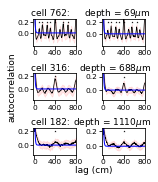

In [175]:
''' example plots '''
# plot example cells
f, ax = plt.subplots(3, 2, figsize=(2, 2.5))
plt.subplots_adjust(hspace=1, wspace=0.6)
OBS_LW = 0.75
CI_LW = 0.5
NULL_LW = 1
SIG_SIZE = 5

for i, cell_ID in enumerate(cell_IDs):
    cdx = np.where(cells==cell_ID)[0][0]
    conf_int_stable = np.squeeze(CI_0[cdx, :, :])
    autocorr_stable = auto_0[cdx, :]
    conf_int_unstable = np.squeeze(CI_1[cdx, :, :])
    autocorr_unstable = auto_1[cdx, :] 

    # find significant peaks
    peak_idx = find_peaks(conf_int_unstable[:, 0], prominence=0.06)[0]
    sig_peak_idx_unstable = peak_idx[np.where(conf_int_unstable[:, 0][peak_idx] > null_autocorr[peak_idx])[0]]
    peak_idx = find_peaks(conf_int_stable[:, 0], prominence=0.06)[0]
    sig_peak_idx_stable = peak_idx[np.where(conf_int_stable[:, 0][peak_idx] > null_autocorr[peak_idx])[0]]

    # plot stable
    ax[i, 0].plot(autocorr_stable, color="k", lw=OBS_LW, label="observed")
    ax[i, 0].fill_between(np.arange(cut_off + 1), conf_int_stable[:, 0], conf_int_stable[:, 1],
                    color="r", lw=CI_LW, alpha=.1, label="95% conf. int.")
    ax[i, 0].plot(null_autocorr, color="b", lw=NULL_LW, label="null model")
    
    # plot unstable
    ax[i, 1].plot(autocorr_unstable, color="k", lw=OBS_LW, label="observed")
    ax[i, 1].fill_between(np.arange(cut_off + 1), conf_int_unstable[:, 0], conf_int_unstable[:, 1],
                    color="r", lw=CI_LW, alpha=.1, label="95% conf. int.")
    ax[i, 1].plot(null_autocorr, color="b", lw=NULL_LW, label="null model") 
    
    # format y axis
    if m == 'Kerala':
        ax[i, 0].set_ylim([ax[i, 0].get_ylim()[0], 0.7])
    else:
        ax[i, 0].set_ylim([ax[i, 0].get_ylim()[0], 0.25])
        ax[i, 0].set_yticks([0, 0.2])    
    ax[i, 1].set_ylim([ax[i, 1].get_ylim()[0], 0.25])
    ax[i, 1].set_yticks([0, 0.2])    
    
    # plot significance
    ylim_0 = ax[i, 0].get_ylim()
    ax[i, 0].scatter(sig_peak_idx_stable, 
                     np.full(sig_peak_idx_stable.shape[0], ylim_0[1]-0.05), 
                     s=SIG_SIZE, lw=0, color='k', marker='*')
    ylim_1 = ax[i, 1].get_ylim()
    ax[i, 1].scatter(sig_peak_idx_stable, 
                     np.full(sig_peak_idx_stable.shape[0], ylim_1[1]-0.05), 
                     s=SIG_SIZE, lw=0, color='k', marker='*')
    
    # format axes
    ax[i, 0].set_xlim([-5, cut_off])
    ax[i, 1].set_xlim([-5, cut_off])
    ax[i, 0].set_xticks(np.arange(0, (pos_max//b)+b, 400//b))
    ax[i, 1].set_xticks(np.arange(0, (pos_max//b)+b, 400//b))
    ax[i, 0].tick_params(which='major', labelsize=7.5, pad=0.5)
    ax[i, 1].tick_params(which='major', labelsize=7.5, pad=0.5)
    ax[i, 0].set_xticklabels(np.arange(0, pos_max+b, 400))
    ax[i, 1].set_xticklabels(np.arange(0, pos_max+b, 400))
    ax[i, 0].set_title("cell {}:".format(cell_ID), fontsize=9, pad=3, loc='right', x=0.85)
    ax[i, 1].set_title("depth = {}$\mu$m".format(depths[i]), fontsize=9, pad=3, loc='right', x=1.15)
        
ax[1, 0].set_ylabel("autocorrelation", fontsize=9, labelpad=1)
ax[2, 1].set_xlabel("lag (cm)", fontsize=9, labelpad=1, horizontalalignment='right', x=0.25)

f.savefig(save_folder + m + '_' + s + '_example_autocorrelations.png', dpi=400, bbox_inches='tight')
plt.show()

In [18]:
''' DECODER ANALYSIS
How do grid cells impact positional decoding?
Remove grid cells vs. an equal number of non-grid spatial cells
'''
import scipy.stats 
from scipy.ndimage import gaussian_filter1d
normcdf = scipy.stats.norm.cdf
normpdf = scipy.stats.norm.pdf

In [19]:
SMOOTHNESS = 10.0
REGULARIZATION = 1e-4

In [20]:
## REGRESSION MODEL ##

from scipy.linalg import cho_factor, cho_solve
from sklearn.base import BaseEstimator

class CircularRegression(BaseEstimator):
    
    def __init__(self, alpha=0.0, tol=1e-5, max_iter=100):
        self.alpha = alpha
        self.tol = tol
        self.max_iter = max_iter
    
    def fit(self, X, y):
        """
        Parameters
        ----------
        X : array
            Independent variables, has shape (n_timepoints x n_neurons)
        y : array
            Circular dependent variable, has shape (n_timepoints x 1),
            all data should lie on the interval [-pi, +pi].
        """
        
        # Convert 1d circular variable to 2d representation
        u = np.column_stack([np.sin(y), np.cos(y)])

        # Randomly initialize weights. Ensure scaling does
        W = np.random.randn(X.shape[1], 2)
        W /= np.max(np.sum(np.abs(X @ W), axis=1))
        
        # Cache neuron x neuron gram matrix. This is used below
        # in the M-step to solve a linear least squares problem
        # in the form inv(XtX) @ XtY. Add regularization term to
        # the diagonal.
        XtX = X.T @ X
        XtX[np.diag_indices_from(XtX)] += self.alpha
        XtX = cho_factor(XtX)

        # Compute model prediction in 2d space, and projection onto
        # each observed u.
        XW = (X @ W)
        t = np.sum(u * XW, axis=1)
        tcdf = normcdf(t)
        tpdf = normpdf(t)

        self.log_like_hist_ = [
            np.log(2 * np.pi) - 
            0.5 * np.mean(np.sum(XW * XW, axis=1), axis=0) +
            np.mean(np.log(1 + t * tcdf / tpdf))
        ]

        for itr in range(self.max_iter):

            # E-step.
            m = t + (tcdf / ((tpdf + t * tcdf)))
            XtY = X.T @ (m[:, None] * u)

            # M-step.
            W = cho_solve(XtX, XtY)
            
            # Recompute model prediction.
            XW = X @ W
            t = np.sum(u * XW, axis=1)
            tcdf = normcdf(t)
            tpdf = normpdf(t)

            # Store log-likelihood.
            self.log_like_hist_.append(
                np.log(2 * np.pi) - 
                0.5 * np.mean(np.sum(XW * XW, axis=1), axis=0) +
                np.mean(np.log(1 + t * tcdf / tpdf))
            )
            
            # Check convergence.
            if (self.log_like_hist_[-1] - self.log_like_hist_[-2]) < self.tol:
                break
    
        self.weights_ = W
    
    def predict(self, X):
        u_pred = X @ self.weights_
        return np.arctan2(u_pred[:, 0], u_pred[:, 1])

    def score(self, X, y):
        """
        Returns 1 minus mean angular similarity between y and model prediction.
        
        score == 1 for perfect prediction
        score == 0 in expectation for random prediction
        score == -1 if prediction is off by 180 degrees.
        """
        y_pred = self.predict(X)
        return np.mean(np.cos(y - y_pred))

In [23]:
''' get X and y - all cells, grids ablated, other spatial ablated, all spatial ablated, non-spatial ablated '''
dt = 0.02
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        print('\n{} {}:'.format(m, s))
        A = d['A']
        B = d['B']
        n_cells = B.shape[1]
        print('n cells = {}'.format(n_cells))
        
        # format position s.t. 0 = -pi = +pi = 400
        y_raw = A[:, 0]
        track_len = 400
        y = (y_raw / np.max(y_raw)) * 2 * np.pi - np.pi
        d['y'] = y        
        
        # all cells
        t_bin = dt
        X = B / t_bin # convert spike count to FR
        X = gaussian_filter1d(X, SMOOTHNESS, axis=0)
        
        # ablate an equal number of grid, non-grid spatial, or non-spatial cells
        # get indices for each cell type
        grid_bool = d['fxn_idx'][0].copy()
        sp_bool = d['stable_cells'].copy()
        ns_bool = np.invert(grid_bool)&np.invert(sp_bool)
#         grid_bool[np.invert(sp_bool)] = False # only keep spatially stable GCs
        n_gc = np.sum(grid_bool)
        print('n GCs = {}'.format(n_gc))
        non_grid_sp = sp_bool & np.invert(grid_bool)
        n_non_grid_sp = np.sum(non_grid_sp)
        print('n non-grid spatial = {}'.format(n_non_grid_sp))
        n_non_sp = np.sum(ns_bool)
        print('n non-spatial = {}'.format(n_non_sp))
        assert((n_gc + n_non_grid_sp + n_non_sp) == n_cells)
        
        # get indices
        not_gc_idx = np.where(np.invert(grid_bool))[0]
        not_sp_idx = np.where(np.invert(non_grid_sp))[0]
        not_ns_idx = np.where(np.invert(ns_bool))[0]
        
        # get N-matched indices
        max_ablated = np.min([n_gc, n_non_grid_sp, n_non_sp])
        n_keep = n_cells - max_ablated
        if (n_cells - n_gc) < n_keep: # need to keep some grid cells
            grids = np.where(grid_bool)[0]
            grids_keep = np.random.choice(grids, n_keep - (n_cells - n_gc), replace=False)
            not_gc_keep = np.append(not_gc_idx, grids_keep)
        else:
            not_gc_keep = np.random.choice(not_gc_idx, n_keep, replace=False)
        not_gc_keep = np.sort(not_gc_keep)   
        print('n grid cells ablated = {}'.format(n_cells - not_gc_keep.shape[0]))
           
        if (n_cells - n_non_grid_sp) < n_keep: # need to keep some non-grid spatial cells
            spatial = np.where(non_grid_sp)[0]
            spatial_keep = np.random.choice(spatial, n_keep - (n_cells - n_non_grid_sp), replace=False)
            not_sp_keep = np.append(not_sp_idx, spatial_keep)
        else:      
            not_sp_keep = np.random.choice(not_sp_idx, n_keep, replace=False)
        not_sp_keep = np.sort(not_sp_keep)
        print('n non-grid spatial cells ablated = {}'.format(n_cells - not_sp_keep.shape[0]))
        
        if (n_cells - n_non_sp) < n_keep: # need to keep some non-spatial cells
            non_spatial = np.where(ns_bool)[0]
            ns_keep = np.random.choice(non_spatial, n_keep - (n_cells - n_non_sp), replace=False)
            not_ns_keep = np.append(not_ns_idx, ns_keep)
        else:      
            not_ns_keep = np.random.choice(not_ns_idx, n_keep, replace=False)
        not_ns_keep = np.sort(not_ns_keep)
        print('n non-spatial cells ablated = {}'.format(n_cells - not_ns_keep.shape[0]))

        # keep the not ablated cells
        X_gc = X[:, not_gc_keep]
        X_sp = X[:, not_sp_keep]
        X_ns = X[:, not_ns_keep]
        assert((n_cells - X_gc.shape[1]) == max_ablated)
        assert((n_cells - X_sp.shape[1]) == max_ablated)
        assert((n_cells - X_ns.shape[1]) == max_ablated)
               
        d['X'] = [X, X_ns, X_gc, X_sp]


Mumbai 1130_1:
n cells = 79
n GCs = 11
n non-grid spatial = 26
n non-spatial = 42
n grid cells ablated = 11
n non-grid spatial cells ablated = 11
n non-spatial cells ablated = 11

Mumbai 1201_1:
n cells = 225
n GCs = 39
n non-grid spatial = 77
n non-spatial = 109
n grid cells ablated = 39
n non-grid spatial cells ablated = 39
n non-spatial cells ablated = 39

Kerala 1207_1:
n cells = 137
n GCs = 61
n non-grid spatial = 27
n non-spatial = 49
n grid cells ablated = 27
n non-grid spatial cells ablated = 27
n non-spatial cells ablated = 27

Goa 1211_1:
n cells = 123
n GCs = 13
n non-grid spatial = 38
n non-spatial = 72
n grid cells ablated = 13
n non-grid spatial cells ablated = 13
n non-spatial cells ablated = 13

Goa 1210_1:
n cells = 177
n GCs = 28
n non-grid spatial = 94
n non-spatial = 55
n grid cells ablated = 28
n non-grid spatial cells ablated = 28
n non-spatial cells ablated = 28

Goa 1209_1:
n cells = 83
n GCs = 11
n non-grid spatial = 25
n non-spatial = 47
n grid cells ablated 

In [24]:
''' downsample to match speed and num observations '''
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        speed = d['A'][:, 1]
        y = d['y']
        map0_idx = d['idx'][0, :]
        map1_idx = d['idx'][1, :]
        
        # bin speed into 10cm/s bins
        edges = np.arange(10, np.max(speed), 10)
        speed_idx = np.digitize(speed, edges)

        # get indices for each map's observations
        all_obs = np.arange(y.shape[0])
        obs_0 = np.arange(y.shape[0])[map0_idx]
        obs_1 = np.arange(y.shape[0])[map1_idx]

        # array to hold indices for downsampling
        ds_all = np.asarray([]) # array to hold indices for downsampling all trials
        ds_0 = np.asarray([]) # array to hold indices for downsampling map 0
        ds_1 = np.asarray([]) # array to hold indices for downsampling map 1

        # match occupancy of each bin for each map
        bins, ct = np.unique(speed_idx, return_counts=True)
        for b in bins:
            occupancy_0 = np.sum(map0_idx[speed_idx == b])
            occupancy_1 = np.sum(map1_idx[speed_idx == b])
            occupancy_all = np.sum(ct[b])    
            idx_0 = np.where(map0_idx & (speed_idx == b))[0]
            idx_1 = np.where(map1_idx & (speed_idx == b))[0]

            if occupancy_0 == occupancy_1:
                ds_all = np.append(ds_all, np.random.choice(all_obs[speed_idx == b], occupancy_0, replace=False))
            elif occupancy_0 > occupancy_1:
                # need to downsample map 0 for this speed bin
                n_timepts = occupancy_1        
                ds_all = np.append(ds_all, np.random.choice(all_obs[speed_idx == b], n_timepts, replace=False))
                ds_0 = np.append(ds_0, np.random.choice(idx_0, n_timepts, replace=False))
                ds_1 = np.append(ds_1, idx_1)
            else:
                # need to downsample map 1 for this speed bin
                n_timepts = occupancy_0
                ds_all = np.append(ds_all, np.random.choice(all_obs[speed_idx == b], n_timepts, replace=False))
                ds_0 = np.append(ds_0, idx_0)
                ds_1 = np.append(ds_1, np.random.choice(idx_1, n_timepts, replace=False)) 
        ds_all = ds_all.astype(int)
        ds_0 = ds_0.astype(int)
        ds_1 = ds_1.astype(int)
        
        d['ds_idx'] = np.row_stack((ds_0, ds_1, ds_all))

In [25]:
# train and test on opposite maps: choose blocks of indices
def train_vs_test_blocks(X, y, train_data_idx, test_data_idx, n_repeats=10, train_pct=0.9):
    test_scores = []    
    test_folds = np.array_split(test_data_idx, n_repeats)

    for i in range(n_repeats):        
        # Get train and test indices
        test_idx = test_folds[i]
        train_idx = np.random.choice(np.setdiff1d(train_data_idx, test_idx),
                                     replace=False, size=int(train_data_idx.size * train_pct))
#         assert(np.round(train_idx.size / (train_pct*n_repeats), -1) == np.round(test_idx.size, -1))

        # Train model
        model.fit(X[train_idx], y[train_idx])

        # Compute test error
        test_scores.append(model.score(X[test_idx], y[test_idx]))
        
    return np.asarray(test_scores)

In [26]:
''' fit model on each condition '''
model = CircularRegression(alpha=REGULARIZATION)

# cross-validate the model
for i in trange(len(mice)):
    m = mice[i]
    session = sessions[i]
    for s in session:
        d = data[m][s]
        y = d['y']
        
        # get downsampled indices 
        ds_0 = d['ds_idx'][0, :]
        ds_1 = d['ds_idx'][1, :]
        ds_all = d['ds_idx'][-1, :]
        
        # get score for each neuron set
        X_set = d['X']
        n_conditions = len(X_set)
        scores = []
        for j in range(n_conditions):
            X = X_set[j]
            random_scores = train_vs_test_blocks(X, y, ds_all, ds_all)
            train0_test0_scores = train_vs_test_blocks(X, y, ds_0, ds_0)
            train1_test1_scores = train_vs_test_blocks(X, y, ds_1, ds_1)
            train0_test1_scores = train_vs_test_blocks(X, y, ds_0, ds_1)
            train1_test0_scores = train_vs_test_blocks(X, y, ds_1, ds_0)
            
            scores_all = random_scores
            scores_within = np.row_stack((train0_test0_scores, train1_test1_scores))
            scores_across = np.row_stack((train1_test0_scores, train0_test1_scores))
            scores.append([scores_all, scores_within, scores_across])
        d['scores'] = scores

100%|█████████████████████| 5/5 [21:22<00:00, 237.50s/it]


In [27]:
# get means and sems
all_means = np.zeros((N_sessions, n_conditions, 3))
all_sems = np.zeros((N_sessions, n_conditions, 3))
i = -1
for m, session in zip(mice, sessions):
    for s in session:
        i+=1
        d = data[m][s]
        scores = d['scores']
        for j in range(len(scores)):
            condition_scores = scores[j]
            for k in range(len(condition_scores)):
                all_means[i, j, k] = np.mean(condition_scores[k])
                all_sems[i, j, k] = stats.sem(np.ravel(condition_scores[k]))          

In [28]:
means = np.ravel(np.mean(all_means, axis=0))
sems = np.ravel(np.mean(all_sems, axis=0))

In [29]:
''' get colors for each condition
dark = both maps
med = within map
light = across maps

grays = all cells
reds = ablate non-spatial (N matched)
oranges = ablate grid cells (N matched)
blues = ablate non-grid spatial cells (N matched)
'''
bar_colors = np.asarray([[0, 0, 0, 255], [80, 80, 80, 255], [119, 119, 119, 255], # grays
                    [114, 25, 14, 255], [165, 23, 14, 255], [220, 5, 12, 255], #reds
                    [241, 147, 45, 255], [246, 193, 65, 255], [247, 240, 86, 255], # oranges
                    [25, 101, 176, 255], [82, 137, 199, 255], [123, 175, 222, 255] # blues
                   ])
bar_colors = bar_colors/255
bar_colors = list(bar_colors)
for i, c in enumerate(bar_colors):
    bar_colors[i] = tuple(c)

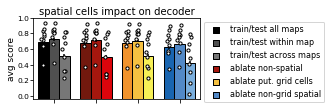

In [34]:
''' plot the results '''
f, ax = plt.subplots(1, 1, figsize=(3, 1.5))
ERR_LW = 1.5
DOT_SIZE = 10
DOT_LW = 1
j = np.random.randn(N_sessions) * .08
xcoords = [1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 15]

# plot data points
for x, c in zip(xcoords[::3], range(n_conditions)):
    session_means = np.squeeze(all_means[:, c, :])
    ax.scatter(np.full(N_sessions, x)+j, session_means[:, 0],
               facecolors='w', edgecolors='k', s=DOT_SIZE, lw=DOT_LW, zorder=3, alpha=1)
    ax.scatter(np.full(N_sessions, x+1)+j, session_means[:, 1],
               facecolors='w', edgecolors='k', s=DOT_SIZE, lw=DOT_LW, zorder=3, alpha=1)
    ax.scatter(np.full(N_sessions, x+2)+j, session_means[:, 2],
               facecolors='w', edgecolors='k', s=DOT_SIZE, lw=DOT_LW, zorder=3, alpha=1)
ylims = ax.get_ylim()
    
# plot means and SEM
err_dict = {'ecolor': 'k', 'elinewidth': ERR_LW}
ax.bar(xcoords, means, width=1, bottom=ylims[0], 
       color=bar_colors, edgecolor='k', 
       yerr=sems, error_kw=err_dict, zorder=1) 

# legend
ax.scatter(21, 0.5, marker='s', c=bar_colors[0], edgecolors='k', label='train/test all maps')
ax.scatter(21, 0.5, marker='s', c=bar_colors[1], edgecolors='k', label='train/test within map')
ax.scatter(21, 0.5, marker='s', c=bar_colors[2], edgecolors='k', label='train/test across maps')
ax.scatter(21, 0.5, marker='s', c=bar_colors[4], edgecolors='k', label='ablate non-spatial')
ax.scatter(21, 0.5, marker='s', c=bar_colors[7], edgecolors='k', label='ablate put. grid cells')
ax.scatter(21, 0.5, marker='s', c=bar_colors[10], edgecolors='k', label='ablate non-grid spatial')

# labels, ticks, axes
ax.set_xlim([0, xcoords[-1]+1])
ax.set_xticks(xcoords[1::3])
ax.set_yticks(np.arange(0, 1.2, 0.2))
ax.set_ylabel('avg score', fontsize=9, labelpad=1)
ax.tick_params(labelbottom=False, which='major', labelsize=7.5, pad=0.5)
ax.set_title('spatial cells impact on decoder', fontsize=10, pad=3)
ax.legend(bbox_to_anchor=(1,1,0,0), loc='upper left', fontsize=8)

f.savefig(save_folder + 'decoder_scores_bar.png', dpi=400, bbox_inches='tight')
plt.show()

In [31]:
print('mean model performance, sem')
print('NON-SPATIAL CELLS ABLATED')
print('train/test on all maps: {}, {}'.format(np.round(means[3], 2), np.round(sems[3], 2)))
print('train/test same map: {}, {}'.format(np.round(means[4], 2), np.round(sems[4], 2)))
print('train/test different maps: {}, {}'.format(np.round(means[5], 2), np.round(sems[5], 2)))

print('\nGRID CELLS ABLATED')
print('train/test on all maps: {}, {}'.format(np.round(means[6], 2), np.round(sems[6], 2)))
print('train/test same map: {}, {}'.format(np.round(means[7], 2), np.round(sems[7], 2)))
print('train/test different maps: {}, {}'.format(np.round(means[8], 2), np.round(sems[8], 2)))

print('\nNON-GRID SPATIAL CELLS ABLATED')
print('train/test on all maps: {}, {}'.format(np.round(means[9], 2), np.round(sems[9], 2)))
print('train/test same map: {}, {}'.format(np.round(means[10], 2), np.round(sems[10], 2)))
print('train/test different maps: {}, {}'.format(np.round(means[11], 2), np.round(sems[11], 2)))

mean model performance, sem
NON-SPATIAL CELLS ABLATED
train/test on all maps: 0.73, 0.03
train/test same map: 0.76, 0.02
train/test different maps: 0.55, 0.03

GRID CELLS ABLATED
train/test on all maps: 0.72, 0.03
train/test same map: 0.75, 0.02
train/test different maps: 0.56, 0.03

NON-GRID SPATIAL CELLS ABLATED
train/test on all maps: 0.67, 0.03
train/test same map: 0.71, 0.02
train/test different maps: 0.46, 0.02


In [32]:
'''groups of comparisons - where are the significant differences?'''
stat, p = stats.kruskal(all_means[:, 1, 0], all_means[:, 1, 1], all_means[:, 1, 2], # non-spatial ablated
                        all_means[:, 2, 0], all_means[:, 2, 1], all_means[:, 2, 2], # grids ablated
                        all_means[:, 3, 0], all_means[:, 3, 1], all_means[:, 3, 2]) # non-grid spatial ablated
print('decoder score with ablations, all comparisons (Kruskal): p = {}'.format(p))

print('\ncompare across ablation conditions')
stat, p = stats.kruskal(all_means[:, 1, 0], all_means[:, 2, 0], all_means[:, 3, 0])
print('train/test all maps (Kruskal): p = {}'.format(p))
stat, p = stats.kruskal(all_means[:, 1, 1], all_means[:, 2, 1], all_means[:, 3, 1])
print('train/test within maps (Kruskal): p = {}'.format(p))
stat, p = stats.kruskal(all_means[:, 1, 2], all_means[:, 2, 2], all_means[:, 3, 2])
print('train/test across maps (Kruskal): p = {}'.format(p))

print('\ncompare across train/test conditions')
stat, p = stats.kruskal(all_means[:, 1, 0], all_means[:, 1, 1], all_means[:, 1, 2])
print('ablate non-spatial cells (Kruskal): p = {}'.format(p))
stat, p = stats.kruskal(all_means[:, 2, 0], all_means[:, 2, 1], all_means[:, 2, 2])
print('ablate putative grid cells (Kruskal): p = {}'.format(p))
stat, p = stats.kruskal(all_means[:, 3, 0], all_means[:, 3, 1], all_means[:, 3, 2])
print('ablate non-grid spatial (Kruskal): p = {}'.format(p))

decoder score with ablations, all comparisons (Kruskal): p = 0.02123401254991431

compare across ablation conditions
train/test all maps (Kruskal): p = 0.6411803884299555
train/test within maps (Kruskal): p = 0.5290436674580616
train/test across maps (Kruskal): p = 0.7114942044274677

compare across train/test conditions
ablate non-spatial cells (Kruskal): p = 0.06863090430109424
ablate putative grid cells (Kruskal): p = 0.06239622882579496
ablate non-grid spatial (Kruskal): p = 0.07833684588675789
